In [24]:
import pandas as pd
import numpy  as np
import re
import string
import plotly
import matplotlib.pyplot as plt
#from nltk.stem import PorterStemmer
import time
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
#from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#from nltk.probability import FreqDist
from wordcloud import WordCloud

In [23]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.Collecting WordCloud
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 435.7 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/300.2 kB 544.7 kB/s eta 0:00:01
   ------------------------- -------------- 194.6/300.2 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.5 MB/s eta 0:00:00




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\VICTUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Stress detection

### Importe de librerias

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

### Lectura del dataset

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com//valemicolgarcia//NLP-Natural-Language-Processing//main//Stress//Stress.csv')
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [29]:
df.shape

(2838, 7)

### Columnas del dataset

DESCRIOCIONN DE LAS COLUMNAS DEL DS

### Distribucion del numero de palabras

Text(0, 0.5, 'Frecuencia')

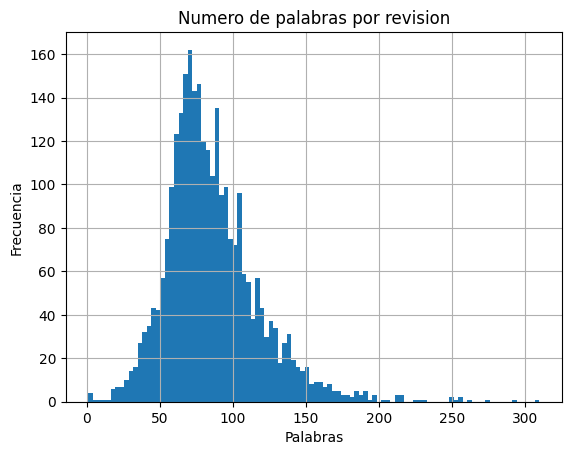

In [30]:
words_per_text = df['text'].apply(lambda x: len(x.split(" ")))
words_per_text.hist(bins = 100)
plt.title('Numero de palabras por revision')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [31]:
words_per_text.mean()

85.84425651867512

### Distribucion de los strings

In [33]:
df['label'].value_counts()

label
1    1488
0    1350
Name: count, dtype: int64

In [34]:
percent_val = 100 * df['label'].value_counts()/df.shape[0]
percent_val

label
1    52.43129
0    47.56871
Name: count, dtype: float64

Text(0, 0.5, 'Porcentaje (%)')

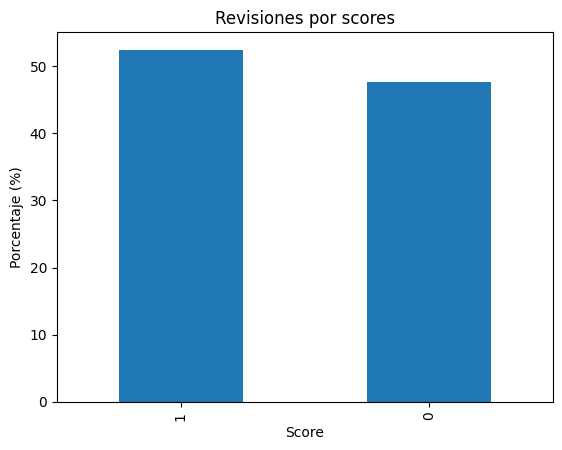

In [35]:
percent_val.plot.bar()
plt.title('Revisiones por scores')
plt.xlabel('Score')
plt.ylabel('Porcentaje (%)')

# WordCloud

1271414


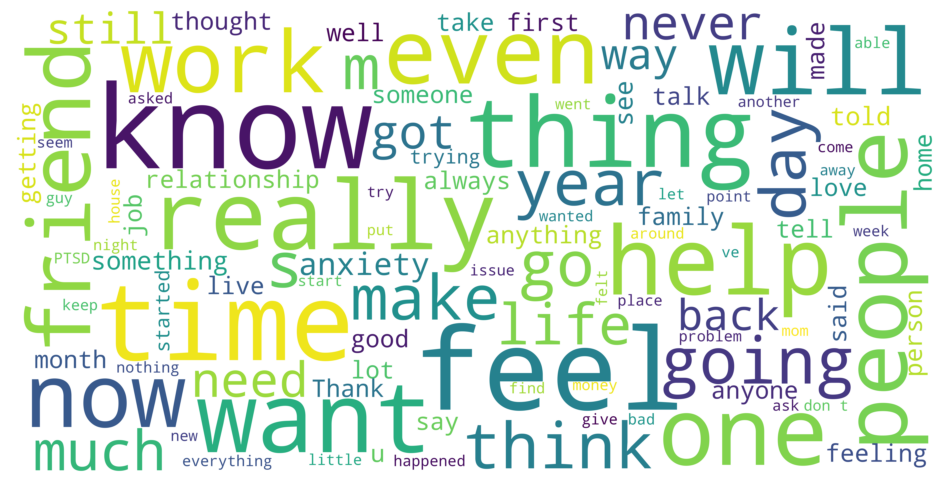

In [36]:
word_cloud_text = ''.join(df['text'])
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Procesamiento con NLTK

Convertir palabras a minusculas

In [37]:
df['text_new'] = df['text'].apply(lambda x: x.lower())

Remuevo los caracteres especiales

In [27]:
pip install nltk

     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     --------- ------------------------------ 10.2/41.5 kB ? eta -:--:--
     -------------------------------------- 41.5/41.5 kB 401.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.2/1.5 MB 7.6 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.5 MB 7.6 MB/s eta 0:00:01
   ----------------------------- ---------- 1.1/1.5 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 8.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/269.7 kB ? eta -:--:--
   --------------------------------------- 269.7/269.7 kB 16.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\VICTUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [47]:
from nltk import word_tokenize
import nltk

nltk.download('punkt') #modelo de tok=kenizacion

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:


token_lists = [word_tokenize(each) for each in df['text']] #se convierte cada texto en una lista
tokens = [item for sublist in token_lists for item in sublist] #es una lista, donde cada sublista tiene los tokens de una postCAMBIAR
print("Numero de tokens unicos antes: ", len(set(tokens))) #se eliminan duplicados con set

token_lists_lower = [word_tokenize(each) for each in df['text_new']] #
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\VICTUS/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\VICTUS\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [46]:
import nltk
print(nltk.data.path)


['C:\\Users\\VICTUS/nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data', 'C:\\Users\\VICTUS\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [44]:
df['text'] = df['text'].fillna('')


In [42]:
df['text'] = df['text'].astype(str)


--------------------------------------------------

In [7]:
Y = df['label']
X = df['text']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
counter = CountVectorizer(stop_words='english')

In [9]:
X_train_v = counter.fit_transform(X_train)
X_test_v = counter.transform(X_test)